## The data grabbed from UHF antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from loop antennas.

In [1]:
# Tato bunka slouzi pro papermill, je oznacena tagem 'parameters'

path = "/storage/experiments/2022/0714_bourka_krivoklatsko_CAR2/parallella/"

session = [
    "/storage/experiments/2022/0714_bourka_krivoklatsko_CAR2/parallella/",
    "/storage/experiments/2022/0714_bourka_horovice_CAR1/parallella/",
    "/storage/experiments/2022/0714_bourka_CAR0/parallella/"
]

In [15]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks


sps = 10e6 # 10 Msps


event = [
 "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68", 
 "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-142820.64",
# "/storage/experiments/2022/0815_bourka_benesov_CAR1/parallella/rec_220815-142821.68"
]

'''
event = [
    "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-144143.86",
    "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-144143.84"
]

event = [
   "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-150322.11",
    "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-150320.91"
]
'''

'\nevent = [\n    "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-144143.86",\n    "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-144143.84"\n]\n\nevent = [\n   "/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-150322.11",\n    "/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-150320.91"\n]\n'

In [20]:
def multistation_plotrec(files):
    
    channels = [0,1,3]
    fig, (ax) = plt.subplots(figsize=(35, 20), nrows=len(channels)*len(files), sharex=True)
    title = None
    
    data = {f:{"filename": f} for f in files}
    print(data)
    
    mintime = None
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        with open(filepath, 'rb') as file:
            fn = os.path.basename(filepath)
            h, samples, synclog = loadrec(file)
            t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
            
            time = s2t(0)
            if not mintime:
                mintime = time
            if mintime > time:
                mintime = time

    print("Znam minimalni cas", mintime)
    
    for j, filepath in enumerate(data):
        print(j, filepath)
        with open(filepath, 'rb') as file:
            fn = os.path.basename(filepath)
            
            h, samples, synclog = loadrec(file)
            t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
            print("zacatek", s2t(0))
            offset = -int(t2s(mintime))
            print("offset", offset)

            if title is not None:
                fig.suptitle(title)

            for i, ch in enumerate(channels):
                i += len(channels)*j
                print(i)

                pre_trigger_blocks = h['preTrigger']
                post_trigger_blocks = h['postTrigger']
               
                a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
                b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
                print(a, b)

                signal_samples = samples[a:b,ch]
                print(a, b, len(samples[:,0]))

                axis_plotrec(ax[i], h, signal_samples, a+offset, b+offset, ticker, formatter, str("{}, channel: {}".format(filepath, ch)))
        print("Done", fn)

    return fig

{'/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68': {'filename': '/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68'}, '/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-142820.64': {'filename': '/storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-142820.64'}}
0 /storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68
1 /storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-142820.64
Znam minimalni cas 2022-08-15 14:28:19.265927399
0 /storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68
zacatek 2022-08-15 14:28:19.300356100
offset 344287
0
0 14614528
0 14614528 14614528
1
0 14614528
0 14614528 14614528
2
0 14614528
0 14614528 14614528
Done rec_220815-142820.68
1 /storage/experiments/2022/0815_bourka_kralupy_CAR0/parallella-VLF/rec_220815-142820.64
zacatek 2022-08-15 14:28:19.2

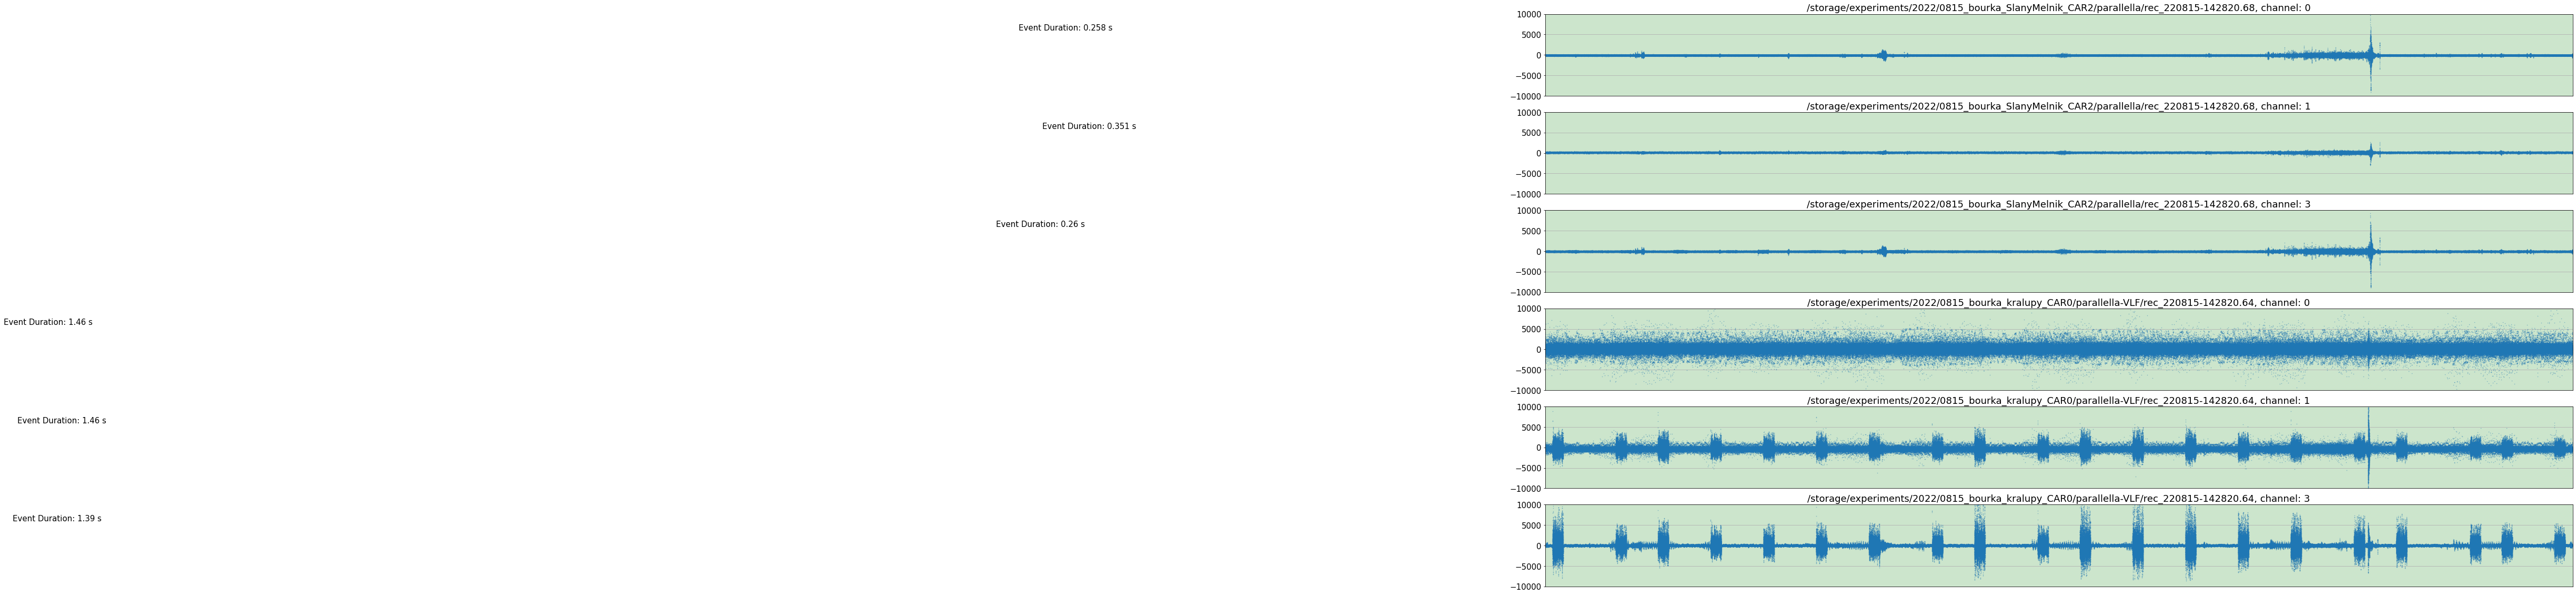

In [25]:
multistation_plotrec(event)
plt.savefig("/storage/experiments/2022/0815_bourka_kralupy_CAR0/compare.png")
plt.xlim(14614528/20*2, 14614528/6)
plt.show()

<Figure size 432x288 with 0 Axes>

## Plotting of the data

In [5]:
import os
pre_trigger_blocks = 380
post_trigger_blocks = 380


pre_trigger_blocks = 100
post_trigger_blocks = 100


matplotlib.rcParams.update({'font.size':15})

for fn in event:
    print(fn)
    if ".csv" in files:
        continue
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            print("File:", fn)
            h, samples, synclog = loadrec(f)
            t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)
            fig = selective_plotrec(h, samples, synclog, os.path.basename(fn),
                    title=os.path.basename(fn),
                    pre_trigger_blocks = pre_trigger_blocks,
                    post_trigger_blocks = post_trigger_blocks,
                    marktimes=ticker,
                    channels = [0,1,3],
                    #channels = [0,1,2,3,4,5,6,7]
                    )
            
            plt.tight_layout()
            try:
                plt.savefig(os.path.join(path, fn)+'.png')
            except Exception as e:
                print(e)
            #plt.savefig('/home/roman/UHF.png')
            plt.show()
   
        except Exception as e:
            print(e)

/storage/experiments/2022/0815_bourka_SlanyMelnik_CAR2/parallella/rec_220815-142820.68


NameError: name 'files' is not defined

Plot all lightning records (High memory and time consuming)

In [4]:
from readrec import selective_plotrec

ImportError: cannot import name 'selective_plotrec' from 'readrec' (/home/roman/repos/CRREAT_cars/UHF_lightning/readrec.py)